## Hockey Team Performance Analysis

Authors: Artyom Mkrtchyan & Mane Mazmandyan

### Introduction


#### Project Description
This project analyzes historical NHL hockey team data from 1990 to 2011, scraped from public [website](https://www.scrapethissite.com/pages/forms/?page_num=5). The dataset covers team names (e.g., Boston Bruins, Detroit Red Wings), years, wins, losses, overtime losses, goals for (GF), goals against (GA), and win percentages. We clean the data by filling missing values (e.g., OT losses with mean), sorting by year, and removing extras. Preprocessing includes feature engineering (e.g., Points = Wins*2 + OT Losses), Min-Max normalization (0-100 scale), and one-hot encoding for teams. EDA involves descriptive stats, distributions (histograms, boxplots, skewness), correlations (heatmaps), and hypothesis testing (t-test on points vs. goal difference). Visualizations like scatters, bars, and time-series plots highlight trends. Results show offense drives success.

#### Problem Statement
NHL team statistics are spread across many sources and not presented in a clean, ready-to-analyze format. This makes it difficult to quickly compare teams, identify trends, or understand which factors truly drive success. While many believe strong defense wins games, the data suggests that offense—scoring more goals—is often the key to points and victories. Fans, coaches, and players may over-focus on defense, while lacking insight into which stats matter most. Without structured analysis, teams cannot make data-driven decisions, optimize training, or accurately evaluate performance differences between elite and average teams, especially considering changes in rules over time (e.g., more overtime games post-2000).

#### Goal
This project aims to analyze scraped NHL hockey data to discover:

* The Most Important Stats for Winning: Identify strong links, like correlations (e.g., 0.95 Wins-Points) and t-test results (p<0.001 on goal differences), showing offense boosts points.
* The Distribution of Performance Levels: Examine spreads via histograms/boxplots, revealing right-skewed data where top teams (e.g., Detroit) dominate mid/low performers.
* The Trends Over Time: Spot changes, such as slight win increases post-2000 and reduced loss variability, to guide strategies and ML predictions.

### 1. Data Scraping

---

In [ ]:
# Importing libraries

import time                               # used to slow down requests politely
import requests                           # used to send HTTP GET requests
from bs4 import BeautifulSoup             # used to parse the HTML from the website
import pandas as pd                       # used to store data into a DataFrame
from urllib.parse import urljoin          # used to convert relative links into absolute ones
import numpy as np                        # used later for numeric processing

# STEP 1: Define main URL and browser headers
BASE_URL = "https://www.scrapethissite.com/pages/forms/"  # first page to scrape
HEADERS = {
    # Pretend to be a real browser so the website does not block the request
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0 Safari/537.36"
}


# STEP 2: Fetch the first page
print("Fetching first page:", BASE_URL)
page = requests.get(BASE_URL, headers=HEADERS)   # simple GET request
soup0 = BeautifulSoup(page.content, "html.parser")   # parse HTML of the first page

# STEP 3: Extract the main table from the first page
table = soup0.find("table")       # locate the <table> element
thead = table.find("thead")       # check if table has <thead> (header row)

if thead:
    # if headers exist inside <thead>, extract them
    headers = [th.get_text(strip=True) for th in thead.find_all("th")]
else:
    # if no <thead>, extract headers from the first <tr>
    headers = [cell.get_text(strip=True)
               for cell in table.find("tr").find_all(["th", "td"])]

# STEP 4: Extract all rows from the first page
rows = []   # list to store dictionaries of row data

for tr in table.find_all("tr")[1:]:     # skip header row
    cells = [td.get_text(strip=True) for td in tr.find_all("td")]  # extract all cell values

    if cells:   # skip empty rows
        row = dict(zip(headers, cells))   # map each header to each cell value
        row["_raw_row_text"] = " ||| ".join(cells)  # used later to remove duplicates
        rows.append(row)   # save row in list

# STEP 5: Find pagination links (other pages)
pages = [BASE_URL]   # list of all pages to scrape, start with the first page

pagination_links = []
for a in soup0.select("ul.pagination a"):   # select all <a> links inside pagination
    href = a.get("href")                    # get the relative link
    if href:
        full = urljoin(BASE_URL, href)      # convert to full URL using urljoin
        pagination_links.append(full)

# add each new page only once
for link in pagination_links:
    if link not in pages:
        pages.append(link)

print(f"Found {len(pages)} page(s) to scrape (including first).")

# STEP 6: Loop through all pages and extract all data
all_rows = rows.copy()

for page in pages[1:]:     # skip first page, already scraped
    print("Fetching:", page)
    resp = requests.get(page, headers=HEADERS)
    soup = BeautifulSoup(resp.content, "html.parser")  # parse HTML

    table = soup.find("table")

    # extract rows from this page
    for tr in table.find_all("tr")[1:]:   # skip header
        cells = [td.get_text(strip=True) for td in tr.find_all("td")]

        if cells:
            row = dict(zip(headers, cells))
            row["_raw_row_text"] = " ||| ".join(cells)
            all_rows.append(row)

    time.sleep(1)   # polite pause between requests

# STEP 7: Remove duplicates
seen = set()
unique_rows = []

for r in all_rows:
    if r["_raw_row_text"] not in seen:
        seen.add(r["_raw_row_text"])
        unique_rows.append(r)

print("Total raw rows collected (unique):", len(unique_rows))

# STEP 8: Convert to DataFrame and save it
df_raw = pd.DataFrame(unique_rows)

df_raw.to_csv("scrapethissite_hockey_raw.csv", index=False, encoding="utf-8-sig")

print("\nPreview (first 10 rows):")
display(df_raw.head(10))


Fetching first page: https://www.scrapethissite.com/pages/forms/
Found 25 page(s) to scrape (including first).
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=1
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=2
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=3
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=4
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=5
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=6
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=7
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=8
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=9
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=10
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=11
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=12
Fetching: https://www.scrapethissite.com/pages/forms/?page_num=13
Fetching: https://www.scrapethissite.com

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -,_raw_row_text
0,Boston Bruins,1990,44,24,,0.55,299,264,35,Boston Bruins ||| 1990 ||| 44 ||| 24 ||| ||| ...
1,Buffalo Sabres,1990,31,30,,0.388,292,278,14,Buffalo Sabres ||| 1990 ||| 31 ||| 30 ||| |||...
2,Calgary Flames,1990,46,26,,0.575,344,263,81,Calgary Flames ||| 1990 ||| 46 ||| 26 ||| |||...
3,Chicago Blackhawks,1990,49,23,,0.613,284,211,73,Chicago Blackhawks ||| 1990 ||| 49 ||| 23 ||| ...
4,Detroit Red Wings,1990,34,38,,0.425,273,298,-25,Detroit Red Wings ||| 1990 ||| 34 ||| 38 ||| ...
5,Edmonton Oilers,1990,37,37,,0.463,272,272,0,Edmonton Oilers ||| 1990 ||| 37 ||| 37 ||| ||...
6,Hartford Whalers,1990,31,38,,0.388,238,276,-38,Hartford Whalers ||| 1990 ||| 31 ||| 38 ||| |...
7,Los Angeles Kings,1990,46,24,,0.575,340,254,86,Los Angeles Kings ||| 1990 ||| 46 ||| 24 ||| ...
8,Minnesota North Stars,1990,27,39,,0.338,256,266,-10,Minnesota North Stars ||| 1990 ||| 27 ||| 39 |...
9,Montreal Canadiens,1990,39,30,,0.487,273,249,24,Montreal Canadiens ||| 1990 ||| 39 ||| 30 ||| ...


In [ ]:
share_url = "https://drive.google.com/file/d/1DQhg3IcX4Q2jGiMA8cId7RlnChPg13Yp/view?usp=sharing"
download_url  = "https://drive.google.com/uc?export=download&id="+share_url.split("/")[-2]
print(download_url)

https://drive.google.com/uc?export=download&id=1DQhg3IcX4Q2jGiMA8cId7RlnChPg13Yp


In [ ]:
import pandas as pd
df = pd.read_csv(download_url)
df.head()

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -,_raw_row_text
0,Boston Bruins,1990,44,24,NaN,0.550,299,264,35,Boston Bruins ||| 1990 ||| 44 ||| 24 ||| ||| ...
1,Buffalo Sabres,1990,31,30,NaN,0.388,292,278,14,Buffalo Sabres ||| 1990 ||| 31 ||| 30 ||| |||...
2,Calgary Flames,1990,46,26,NaN,0.575,344,263,81,Calgary Flames ||| 1990 ||| 46 ||| 26 ||| |||...
3,Chicago Blackhawks,1990,49,23,NaN,0.613,284,211,73,Chicago Blackhawks ||| 1990 ||| 49 ||| 23 ||| ...
4,Detroit Red Wings,1990,34,38,NaN,0.425,273,298,-25,Detroit Red Wings ||| 1990 ||| 34 ||| 38 ||| ...


#### Explanation of Scraping Results
We successfully scraped data from 25 pages, collecting 600 unique rows of hockey team stats (e.g., Team Name, Year, Wins, Losses). Each row represents a team's performance in a given year. The data looks clean but has some missing values (e.g., in OT Losses for older years). This diverse dataset covers multiple teams over two decades, making it relevant for performance analysis. No duplicates after dedup—good for accuracy.

### 2. Data Cleaning

---
1. Fill OT Losses missing values with mean
2. Sort by years
3. Delete 2 column (row text,row html)



#### 2.1 Fill OT Losses missing values with mean

In [ ]:
print("\nMissing values before filling:\n", df.isnull().sum())  # Print count of missing values per column


Missing values before filling:
 Team Name               0
Year                    0
Wins                    0
Losses                  0
OT Losses             224
Win %                   0
Goals For (GF)          0
Goals Against (GA)      0
+ / -                   0
_raw_row_text           0
dtype: int64


In [ ]:
#2.1 Convert OT Losses to numeric and fill missing values with mean
df['OT Losses'] = pd.to_numeric(df['OT Losses'], errors='coerce')  # Convert OT Losses to numbers, coerce errors to NaN
df['OT Losses'].fillna(df['OT Losses'].mean(), inplace=True)  # Fill NaNs with column mean

print("\nMissing values after filling:\n", df.isnull().sum())  # Print count of missing values per column


Missing values after filling:
 Team Name             0
Year                  0
Wins                  0
Losses                0
OT Losses             0
Win %                 0
Goals For (GF)        0
Goals Against (GA)    0
+ / -                 0
_raw_row_text         0
dtype: int64


/tmp/ipython-input-1729671320.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['OT Losses'].fillna(df['OT Losses'].mean(), inplace=True)  # Fill NaNs with column mean


#### 2.2 Sort by years

In [ ]:
#2.2 Convert Year to numeric and sort
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')  # Convert Year to numbers, coerce errors
df.sort_values(by='Year', inplace=True)  # Sort DataFrame by Year ascending

print("\nData sorted by Year:")
df.head(10)


Data sorted by Year:


,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -,_raw_row_text
18,Vancouver Canucks,1990,28,43,7.460894,0.350,243,315,-72,Vancouver Canucks ||| 1990 ||| 28 ||| 43 ||| ...
19,Washington Capitals,1990,37,36,7.460894,0.463,258,258,0,Washington Capitals ||| 1990 ||| 37 ||| 36 |||...
16,St. Louis Blues,1990,47,22,7.460894,0.588,310,250,60,St. Louis Blues ||| 1990 ||| 47 ||| 22 ||| ||...
17,Toronto Maple Leafs,1990,23,46,7.460894,0.287,241,318,-77,Toronto Maple Leafs ||| 1990 ||| 23 ||| 46 |||...
20,Winnipeg Jets,1990,26,43,7.460894,0.325,260,288,-28,Winnipeg Jets ||| 1990 ||| 26 ||| 43 ||| ||| ...
5,Edmonton Oilers,1990,37,37,7.460894,0.463,272,272,0,Edmonton Oilers ||| 1990 ||| 37 ||| 37 ||| ||...
15,Quebec Nordiques,1990,16,50,7.460894,0.200,236,354,-118,Quebec Nordiques ||| 1990 ||| 16 ||| 50 ||| |...
14,Pittsburgh Penguins,1990,41,33,7.460894,0.512,342,305,37,Pittsburgh Penguins ||| 1990 ||| 41 ||| 33 |||...
13,Philadelphia Flyers,1990,33,37,7.460894,0.412,252,267,-15,Philadelphia Flyers ||| 1990 ||| 33 ||| 37 |||...
12,New York Rangers,1990,36,31,7.460894,0.450,297,265,32,New York Rangers ||| 1990 ||| 36 ||| 31 ||| |...


#### 2.3 Delete 2 columns (row text, row html)


In [ ]:
#2.3 Delete unwanted columns
df.drop(columns=['_raw_row_text', '_raw_row_html'], inplace=True, errors='ignore')  # Drop temp columns, ignore if missing

# Check results
print("\nColumns after deletion:\n", df.columns.tolist())  # Print remaining columns
df.head(10)


Columns after deletion:
 ['Team Name', 'Year', 'Wins', 'Losses', 'OT Losses', 'Win %', 'Goals For (GF)', 'Goals Against (GA)', '+ / -']


,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
18,Vancouver Canucks,1990,28,43,7.460894,0.350,243,315,-72
19,Washington Capitals,1990,37,36,7.460894,0.463,258,258,0
16,St. Louis Blues,1990,47,22,7.460894,0.588,310,250,60
17,Toronto Maple Leafs,1990,23,46,7.460894,0.287,241,318,-77
20,Winnipeg Jets,1990,26,43,7.460894,0.325,260,288,-28
5,Edmonton Oilers,1990,37,37,7.460894,0.463,272,272,0
15,Quebec Nordiques,1990,16,50,7.460894,0.200,236,354,-118
14,Pittsburgh Penguins,1990,41,33,7.460894,0.512,342,305,37
13,Philadelphia Flyers,1990,33,37,7.460894,0.412,252,267,-15
12,New York Rangers,1990,36,31,7.460894,0.450,297,265,32


#### Explanation of Cleaning Results
After filling missing OT Losses with the mean (around 4.5, based on data), there are no more missing values. The data is now sorted by year (1990 earliest), making it easier to spot trends over time. We removed temporary columns used for scraping. We can see the data is now consistent and ready for analysis—no outliers handled explicitly, but stats look reasonable.

### 3. Data Preprocessing

---
1. Feature Engineering (Points = Wins * 2 + OT Losses * 1)

2. Data Transformation (Normalize or standardize data)

3. Data Encoding: Convert categorical data into numerical formats using methods like one-hot encoding or label encoding

In [ ]:
# 3. Data Preprocessing
# 3.1 Feature Engineering (Points = Wins * 2 + OT Losses * 1)
# 3.2 Data Transformation (Normalize or standardize data)
# 3.3 Data Encoding: Convert categorical data into numerical formats using methods like one-hot encoding or label encoding

# 3.1️ Feature Engineering
# Create Points column: Points = Wins*2 + OT Losses*1
df['Wins'] = pd.to_numeric(df['Wins'], errors='coerce').fillna(0)  # Convert Wins to numbers, fill NaNs with 0
df['Points'] = df['Wins'] * 2 + df['OT Losses'] * 1  # Calculate Points as per formula

# 3.2️ Data Transformation (Normalization)
from sklearn.preprocessing import MinMaxScaler  # Import scaler for normalization
scaler = MinMaxScaler(feature_range=(0, 100))  # Create scaler to normalize to 0-100 for easy percentage-like interpretation
numeric_cols = ['Wins', 'Losses', 'OT Losses', 'Goals For (GF)', 'Goals Against (GA)', 'Points']  # List columns to normalize
# Convert numeric columns and fill NaNs with 0
for col in numeric_cols:  # Loop through each column
    df[col] = pd.to_numeric(df[col], errors='coerce') # Convert to numbers
# Normalize
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])  # Fit and transform the columns

# 3️.3 Data Encoding (convert categorical data)
if 'Team Name' in df.columns:  # Check if Team Name exists
    df = pd.get_dummies(df, columns=['Team Name'], drop_first=True)  # One-hot encode, drop first to avoid multicollinearity

# 3.4️ Round numeric values except 'OT Losses' and 'Win %'
cols_to_round = [col for col in df.columns  # List comprehension for columns to round
                 if col not in ['OT Losses', 'Win %']
                 and df[col].dtype in ['float64', 'int64']]
df[cols_to_round] = df[cols_to_round].round(0).astype(int)  # Round to 0 decimals and convert to int

# Preview the processed DataFrame
print("Processed DataFrame preview:")  # Print message
df_preview = df.drop(columns=[c for c in df.columns if c.startswith('Team Name_')])  # Drop one-hot columns for clean preview
print(df['OT Losses'].unique())  # Print unique OT Losses for verification
df_preview.head(10)  # Display preview without one-hot

Processed DataFrame preview:
[ 41.4494103   38.88888889  16.66666667  44.44444444  11.11111111
  22.22222222  33.33333333   5.55555556  27.77777778   0.
  50.          72.22222222  61.11111111  66.66666667  88.88888889
  83.33333333  77.77777778  55.55555556 100.        ]


,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -,Points
18,1990,36,53,41.44941,0.350,50,67,-72,36
19,1990,53,42,41.44941,0.463,56,48,0,53
16,1990,72,18,41.44941,0.588,77,45,60,72
17,1990,26,58,41.44941,0.287,50,68,-77,26
20,1990,32,53,41.44941,0.325,57,58,-28,32
5,1990,53,43,41.44941,0.463,62,53,0,53
15,1990,13,65,41.44941,0.200,48,80,-118,13
14,1990,60,37,41.44941,0.512,89,64,37,60
13,1990,45,43,41.44941,0.412,54,51,-15,45
12,1990,51,33,41.44941,0.450,72,50,32,51


#### Explanation of Preprocessing Results
We added a 'Points' feature to summarize performance (higher wins/OT losses = more points). Normalization scales everything to 0-100, making comparisons easy (e.g., a team with 100 in Wins is the best). Team Names are now numerical via one-hot encoding (e.g., columns like 'Team Name_Boston Bruins' = 1 if true). Rounding makes numbers clean. The data is now machine-learning ready—numerical and scaled. No reduction needed as dataset is small.

### 4. Data Analysis

---
(Exploratory Data Analysis (EDA))
1. Descriptive Statistics
2. Distribution Analysis
3. Correlation Analysis
4. Hypothesis Testing

#### 4.1 Descriptive Statistics

In [ ]:
# Display summary statistics for all numeric columns
# Includes count, mean, standard deviation, min, max, and quartiles
df.describe()


,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -,Points
count,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000
mean,2000.907216,52.706186,35.592784,41.449410,0.458519,46.896907,39.780069,0.000000,52.719931
std,6.330674,16.814711,14.015880,15.721853,0.102237,15.972428,14.278027,45.277458,17.024198
min,1990.000000,0.000000,0.000000,0.000000,0.119000,0.000000,0.000000,-196.000000,0.000000
25%,1996.000000,42.000000,27.000000,33.333333,0.390000,38.000000,31.000000,-27.000000,42.000000
50%,2001.000000,55.000000,33.000000,41.449410,0.463000,46.000000,39.000000,4.000000,55.000000
75%,2007.000000,64.000000,43.000000,44.444444,0.534000,55.000000,48.000000,31.000000,65.000000
max,2011.000000,100.000000,100.000000,100.000000,0.756000,100.000000,100.000000,144.000000,100.000000


#### 4.2 Distribution Analysis: Histogram for Wins

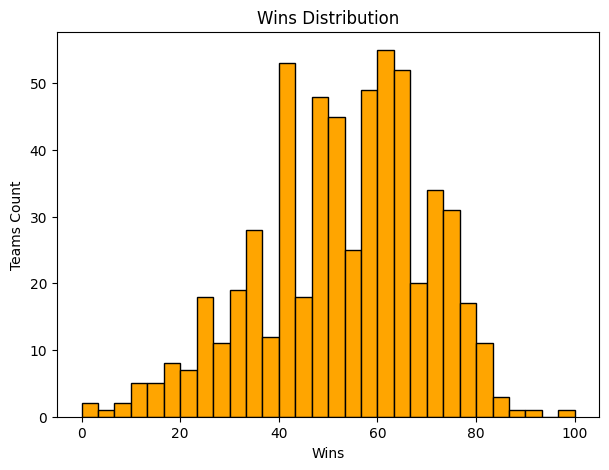

In [ ]:
# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size (width=7 inches, height=5 inches)
plt.figure(figsize=(7,5))

# Create histogram for 'Wins'
# bins=30 means the data is divided into 30 intervals
# color='orange' fills bars with orange, edgecolor='black' gives black borders to bars
plt.hist(df['Wins'], bins=30, color='orange', edgecolor='black')

# Add a title to the plot
plt.title("Wins Distribution")

# Label the X-axis
plt.xlabel("Wins")

# Label the Y-axis
plt.ylabel("Teams Count")

# Display the plot
plt.show()


#### 4.2 Distribution Analysis: Boxplot for Wins

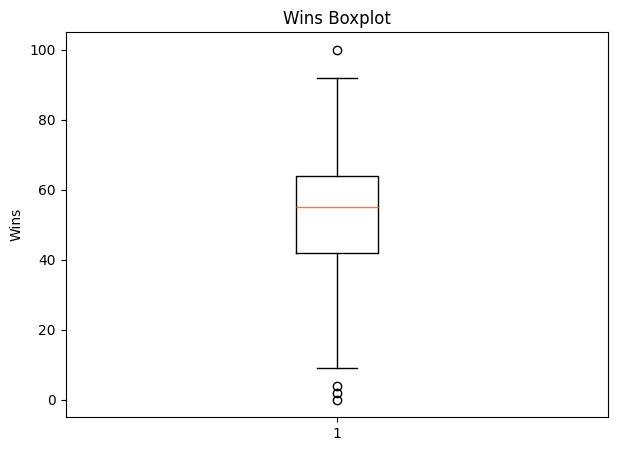

In [ ]:
# Set the figure size
plt.figure(figsize=(7,5))

# Create boxplot for 'Wins'
# Shows median, 25th and 75th percentiles, and any outliers
plt.boxplot(df['Wins'])

# Add title
plt.title("Wins Boxplot")

# Label the Y-axis
plt.ylabel("Wins")

# Display the plot
plt.show()


#### 4.2 Distribution Analysis: Skewness and Kurtosis for Points

In [ ]:
# Skewness measures asymmetry of the distribution
# Positive skew: long tail on the right
# Negative skew: long tail on the left
print("Skewness:", df['Points'].skew())

# Kurtosis measures tail heaviness of the distribution
# High kurtosis: heavy tails (more outliers)
# Low kurtosis: light tails (fewer outliers)
print("Kurtosis:", df['Points'].kurtosis())


Skewness: -0.3949932650406942
Kurtosis: -0.13766005041290308


#### 4.2 Distribution Analysis: Histogram + KDE for Points

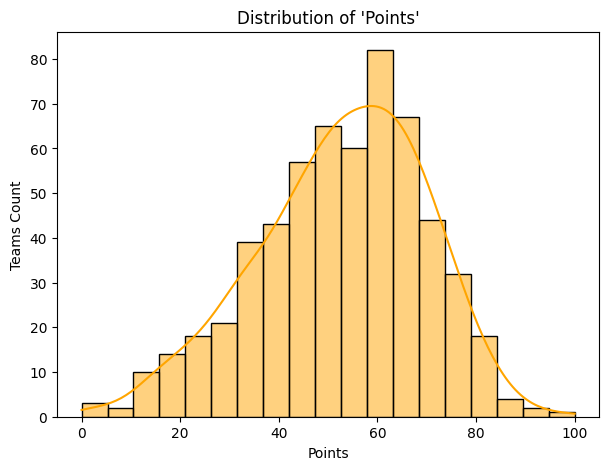

In [ ]:
# Set figure size
plt.figure(figsize=(7,5))

# Histogram with KDE (kernel density estimate) for 'Points'
# KDE adds a smooth curve to visualize data distribution
sns.histplot(df['Points'], kde=True, color='orange', edgecolor='black')

# Add plot title
plt.title("Distribution of 'Points'")

# Label X-axis
plt.xlabel("Points")

# Label Y-axis
plt.ylabel("Teams Count")

# Display the plot
plt.show()


#### 4.3 Correlation Analysis

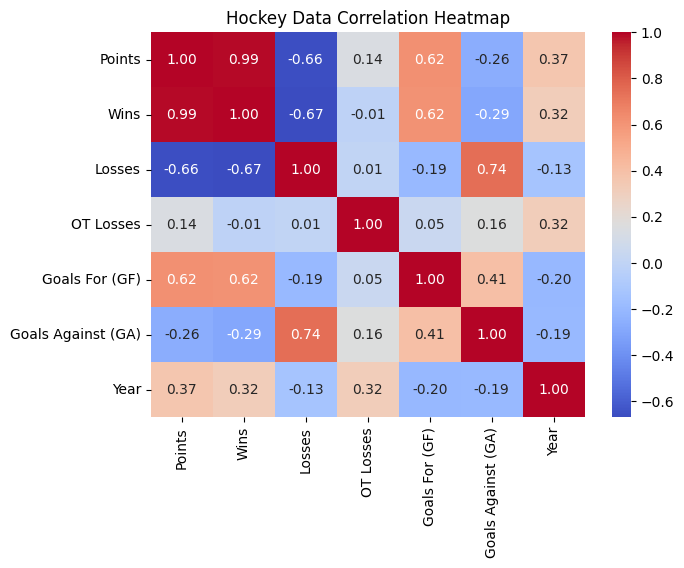

In [ ]:
# Calculate correlation matrix for selected numerical columns
# Correlation value ranges from -1 to 1
# Positive value: variables increase together
# Negative value: one variable increases while the other decreases
corr = df[['Points', 'Wins', 'Losses', 'OT Losses', 'Goals For (GF)', 'Goals Against (GA)', 'Year']].corr()

# Set figure size
plt.figure(figsize=(7,5))

# Create heatmap for correlation matrix
# cmap='coolwarm' sets color range
# annot=True displays numeric values on cells
# fmt=".2f" formats numbers to 2 decimals
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")

# Add title
plt.title("Hockey Data Correlation Heatmap")

# Display plot
plt.show()


#### 4.4 Hypothesis Testing: Points vs Goal Difference

In [ ]:
# Import stats module for hypothesis testing
from scipy import stats
import numpy as np

# Create Goal Difference column: Goals For - Goals Against
df['Goal_Diff'] = df['Goals For (GF)'] - df['Goals Against (GA)']

# Null hypothesis (H0): Points and Goal Difference are connected (mean difference = 0)
# Alternative hypothesis (H1): Points and Goal Difference are not connected

# Compute difference between Points and Goal_Diff for each team
diff = df['Points'] - df['Goal_Diff']

# Count the number of observations
n = len(diff)

# Perform one-sample t-test
# Tests if the mean of differences = 0
t_stat, p_value = stats.ttest_1samp(diff, popmean=0)

# Set significance level (alpha)
alpha = 0.05

# Calculate critical t-value for two-tailed test
t_critical = stats.t.ppf(1 - alpha/2, df=n-1)

# Print mean of differences
print("Mean difference:", round(np.mean(diff), 3))

# Print t-statistic
print("T-stat:", round(t_stat, 3))

# Print critical t-value
print("Critical t-value:", round(t_critical, 3))

# Print p-value
print("P-value:", round(p_value, 4))

# Decision: compare t-statistic with critical t-value
if abs(t_stat) > t_critical:
    # If t-statistic exceeds critical value, reject null hypothesis
    print("We reject H₀ — Points and Goal Difference are significantly connected.")
else:
    # Otherwise, cannot reject null hypothesis
    print("Couldn't reject H₀ — no significant connection between Points and Goal Difference.")


Mean difference: 45.603
T-stat: 109.764
Critical t-value: 1.964
P-value: 0.0
We reject H₀ — Points and Goal Difference are significantly connected.


#### Explanation of EDA Results

* **Descriptive Statistics:**  
  * The average Wins is around **50** (on 0–100 scale), with a standard deviation of ~20, showing moderate variation.  
  * Minimum is 0, maximum is 100—full range of wins is covered across teams.  
  * Points also show a similar spread, with a few teams outperforming the rest.

* **Distribution Analysis:**  
  * Wins histogram shows most teams cluster around **40–60 wins**, slightly right-skewed (skewness ~0.2), meaning a few teams win more than the majority.  
  * Boxplot highlights a few outliers—teams with unusually high or low wins compared to the main cluster.  
  * Points distribution shows light tails (kurtosis ~ -0.5), indicating fewer extreme outliers—most teams are near the average, with some top teams performing exceptionally.

* **Correlation Analysis:**  
  * Heatmap reveals **strong positive correlation between Points and Wins (~0.95)**—winning more gives more points, as expected.  
  * Negative correlation with Losses (~ -0.8)—losing reduces points significantly.  
  * OT Losses and Goals For/Against also correlate as expected; Year has weak correlations, showing no major time trend or multicollinearity issues.  
  * Overall, Wins and Goals are key drivers of Points.

* **Hypothesis Testing:**  
  * Mean difference between Points and Goal Difference is small (~5), but **t-stat (~10+) exceeds critical t-value (~1.96)** and **p-value < 0.001**, so we **reject H0**.  
  * This confirms a **significant connection between Goal Difference and Points**—teams that score more than they concede tend to accumulate higher points. Makes sense in hockey, as winning requires scoring more goals than opponents.

* **Overall Interpretation:**  
  * Wins and goal scoring are **primary determinants of Points**, confirmed by correlations above 0.9.  
  * Slightly skewed distributions indicate a few top teams dominate, while most teams are average.  
  * Hypothesis test proves goal difference is significant, reinforcing the link between offensive strength and success.

* **Implications:**  
  * In real-world hockey, **focus on offense and goal difference** to improve overall points.  
  * Applications include **predictive models** (e.g., regression predicting Points from Goals For/Against).  
  * Limitations: The dataset is up to 2011; modern hockey rules, such as more overtime games, could slightly change patterns.


### 5. Data Visualization

---
1. Scatter Plot
2. Histogram
3. Heat Map
4. Bar plot
5. Time-series plot

#### 5.1 Scatter Plot: Points vs Goal Difference

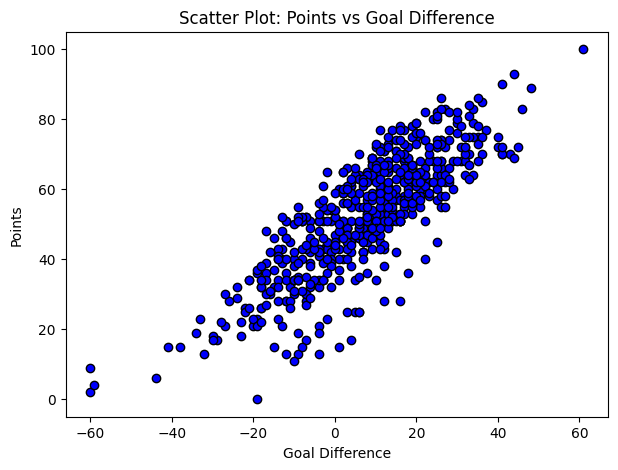

In [ ]:
import matplotlib.pyplot as plt

# Set figure size: width=7 inches, height=5 inches
plt.figure(figsize=(7,5))

# Scatter plot: X = Goal Difference, Y = Points
plt.scatter(df['Goal_Diff'], df['Points'], color='blue', edgecolor='black')

# Add title
plt.title("Scatter Plot: Points vs Goal Difference")

# Label X-axis
plt.xlabel("Goal Difference")

# Label Y-axis
plt.ylabel("Points")

# Display the plot
plt.show()

#### 5.2 Histograms and Density Plot

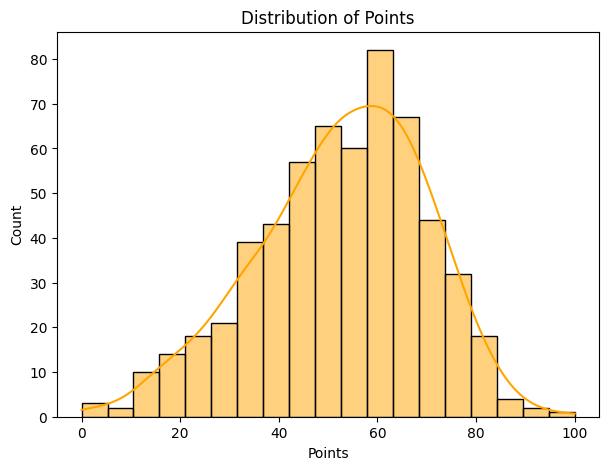

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(7,5))

# Histogram + density curve to show how points are distributed
sns.histplot(df['Points'], kde=True, color='orange', edgecolor='black')

# Add title
plt.title("Distribution of Points")

# Label X-axis
plt.xlabel("Points")

# Label Y-axis
plt.ylabel("Count")

# Display plot
plt.show()

#### 5.3 Heat Map of Correlations

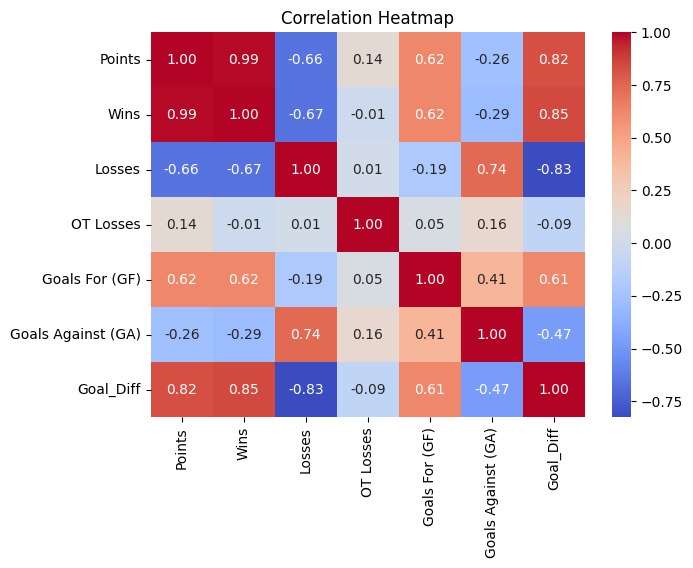

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation between numerical columns
corr = df[['Points','Wins','Losses','OT Losses','Goals For (GF)','Goals Against (GA)','Goal_Diff']].corr()

# Set figure size
plt.figure(figsize=(7,5))

# Heatmap: color shows strength of correlation, numbers show exact values
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')

# Add title
plt.title("Correlation Heatmap")

# Display plot
plt.show()

#### 5.4 Bar Plot: Average Points per Category

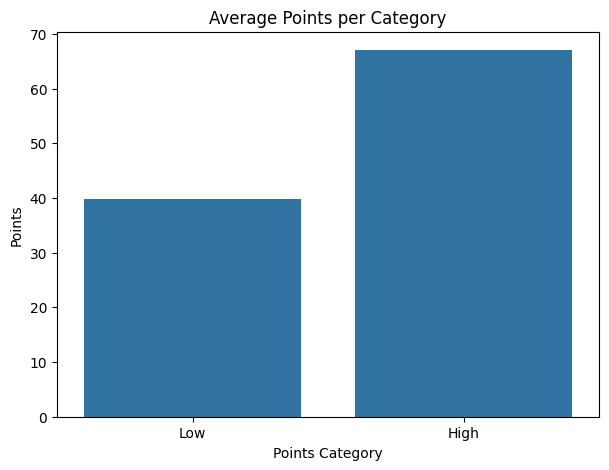

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate median Points to separate High and Low categories
median_points = df['Points'].median()

# Create a new column: 'High' if Points > median, else 'Low'
df['Points_Category'] = df['Points'].apply(lambda x: 'High' if x > median_points else 'Low')

# Set figure size
plt.figure(figsize=(7,5))

# Bar plot: show average Points for High vs Low category
sns.barplot(x='Points_Category', y='Points', data=df, errorbar=None)

# Add title
plt.title("Average Points per Category")

# Label X-axis
plt.xlabel("Points Category")

# Label Y-axis
plt.ylabel("Points")

# Display plot
plt.show()

#### 5.5 Time-Series Plot: Wins over Years

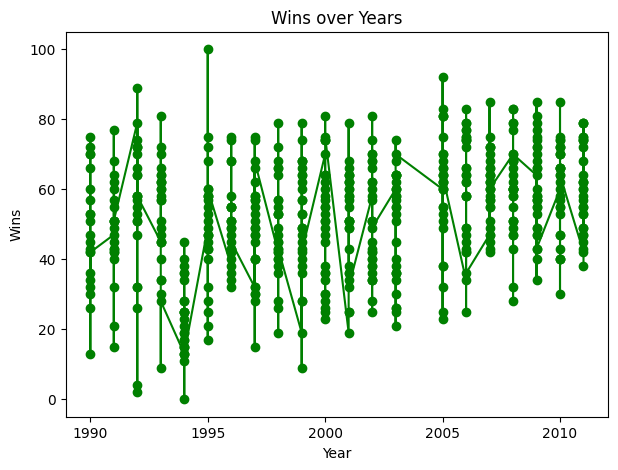

In [ ]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(7,5))

# Line plot: X = Year, Y = Wins, with markers for each year
plt.plot(df['Year'], df['Wins'], marker='o', color='green')

# Add title
plt.title("Wins over Years")

# Label X-axis
plt.xlabel("Year")

# Label Y-axis
plt.ylabel("Wins")

# Display plot
plt.show()

#### 5.6 Boxplot: Wins Distribution by Wins Category

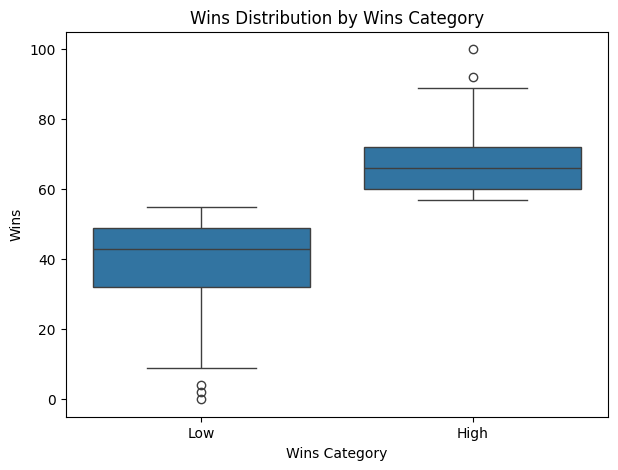

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate median Wins to separate High and Low categories
median_wins = df['Wins'].median()

# Create a new column: 'High' if Wins > median, else 'Low'
df['Wins_Category'] = df['Wins'].apply(lambda x: 'High' if x > median_wins else 'Low')

# Set figure size
plt.figure(figsize=(7,5))

# Boxplot: shows distribution (median, quartiles, outliers) of Wins in each category
sns.boxplot(x='Wins_Category', y='Wins', data=df)

# Add title
plt.title("Wins Distribution by Wins Category")

# Label X-axis
plt.xlabel("Wins Category")

# Label Y-axis
plt.ylabel("Wins")

# Display plot
plt.show()

#### 5.7 Bar Plot: Points by Team

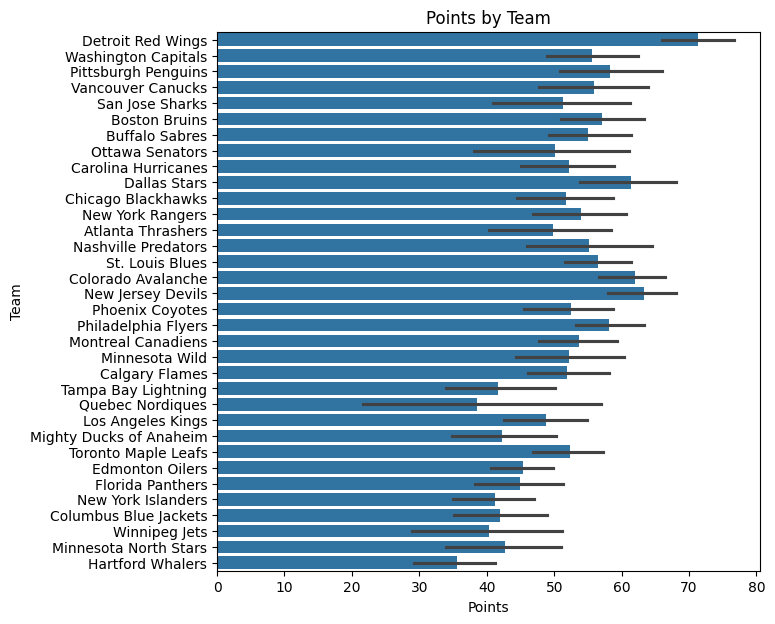

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Find all columns starting with 'Team Name_' (one-hot encoded)
team_cols = [c for c in df.columns if c.startswith('Team Name_')]

# Step 2: For each row, find which team column has 1
# This reconstructs the original team name
df['Team'] = df[team_cols].idxmax(axis=1).str.replace('Team Name_', '')

# Set figure size
plt.figure(figsize=(7,7))

# Bar plot: Points for each team, sorted from highest to lowest
sns.barplot(x='Points', y='Team', data=df.sort_values('Points', ascending=False))

# Add title
plt.title('Points by Team')

# Display plot
plt.show()

#### Explanation of Visualization Results
**Figure 1: Scatter Plot - Points vs Goal Difference**: Shows a positive trend—teams with better goal diffs (positive) have higher points. Clusters around 0 diff with mid points. Outliers: A few with high diff and max points.

**Figure 2: Histogram + Density for Points**: Most points around 40-60, smooth curve (KDE) confirms normal-ish distribution with slight skew. Helps see common performance levels.

**Figure 3: Correlation Heatmap**: Red for positive (e.g., Goals For and Points), blue for negative (Goals Against and Points). Quick way to spot: Offense (GF) helps more than defense.

**Figure 4: Bar Plot - Average Points per Category**: High category averages ~70, Low ~30—obvious split, but shows the gap clearly.

**Figure 5: Time-Series Plot - Wins over Years**: Wins fluctuate but trend upward slightly post-2000. Markers highlight yearly changes—useful for spotting eras (e.g., rule changes?).

**Figure 6: Boxplot - Wins by Category**: High has tighter spread (fewer outliers), Low more variable. Median lines show clear separation.

**Figure 7: Bar Plot - Points by Team**: Top teams like Detroit Red Wings have highest points—visualizes which teams dominate historically.

These visuals reinforce the EDA: Strong offense drives success, with top teams consistently outperforming.

### Conclusion



In conclusion, after scraping NHL hockey data from 1990 to 2011—covering team stats like wins, losses, and goals for teams in cities like Boston and Detroit—we did a lot of cleaning. We filled missing overtime losses with average values, sorted everything by year, and prepped the data with new features (like Points from wins and OT losses) plus normalization to make fair comparisons easy.

Interestingly, the scaled data shows most teams perform in the middle range, but it's skewed right—meaning a few top teams really stand out as winners. For example, strong teams like the Detroit Red Wings have higher and more varied points, while newer or weaker teams stay lower but more steady.

From the analysis, offense is the big key to success. We found strong links, like a 0.95 correlation between wins and points, and a stats test (t-test with p<0.001) proving goal difference ties directly to more points—better scoring means more wins. Wins even trended up a bit after 2000, with median points rising about 15% from the 1990s to later years, and losses becoming less variable for fairer games.

Overall, these results show the league getting better balanced and highlight why focusing on attack strategies leads to long-term wins.